# COVID-19's Impact on Airport Traffic

## Analysis of Traffic Volume Post-COVID

### Motivation

The COVID-19 pandemic has a catastrophic impact on the global aviation industry as a whole, causing significant disruptions to air travel and a partial halt in air transport operations amid widespread isolation, the closure of international borders and severe travel restrictions to all regions of the planet.

I tried to explore the given data and check the COVID-19's Impact on Airport Traffic.

### Libraries loading

In [41]:
import numpy as np
import pandas as pd
import folium
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
import math
import scipy
from scipy import stats

In [2]:
%matplotlib inline

### Data loading

In [3]:
data = pd.read_csv('covid_impact_on_airport_traffic.csv')

In [4]:
data.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


In [5]:
min(data['Date']), max(data['Date'])

('2020-03-16', '2020-12-02')

This dataset shows traffic to and from the Airport as a Percentage of the Traffic volume during the baseline period. The baseline period used for computing this metric is from 1st Feb to 15th March 2020. The dataset gets updated daily. The data was collected from 16th March 2020 to 12th December 2020.

Dataset has 11 columns:
 + AggregationMethod: Aggregation period used to compute this metric
 + Date: Date in format YYYY-MM-DD
 + Version: Version # of this dataset
 + AirportName: Name of airport
 + PercentOfBaseline: Proportion of trips on this date as compared to Avg number of trips on the same day of week in baseline period i.e 1st February 2020 - 15th March 2020
 + Centroid: Geography representing centroid of the Airport polygon
 + City: City within which the Airport is located
 + State: State within which the Airport is located
 + ISO_3166_2: ISO-3166-2 code representing Country and Subdivision
 + Country: Country within which the Airport is located
 + Geography: Polygon of the Airport that is used to compute this metric

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
AggregationMethod    7247 non-null object
Date                 7247 non-null object
Version              7247 non-null float64
AirportName          7247 non-null object
PercentOfBaseline    7247 non-null int64
Centroid             7247 non-null object
City                 7247 non-null object
State                7247 non-null object
ISO_3166_2           7247 non-null object
Country              7247 non-null object
Geography            7247 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


There are no null data.

### Preprocessing

In [7]:
data['Date'] = data['Date'].map(lambda x: date.fromisoformat(x))

The weekday() function of date class in datetime module, returns an integer corresponding to the day of the week. 
 + 0: Monday
 + 1: Tuesday
 + 2: Wednesday
 + 3: Thursday
 + 4: Friday
 + 5: Saturday
 + 6: Sunday

In [8]:
data['Weekday'] = data['Date'].map(lambda x: x.weekday())
w_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
data['Weekday'] = [w_list[idx] for idx in data['Weekday']]

In [9]:
data['Weekday']

0       Fri
1       Mon
2       Fri
3       Wed
4       Sat
       ... 
7242    Fri
7243    Sat
7244    Thu
7245    Fri
7246    Sun
Name: Weekday, Length: 7247, dtype: object

Creating latitude and longitude columns.

In [53]:
def cut_long(point):
    """
   Функция, которая "вырезает" значение долготы.
   """
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    long, _ = point[6:-1].split(" ")
    return float(long)

def cut_lat(point):
    """
   Функция, которая "вырезает" значение широты.
   """
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    _, lat = point[6:-1].split(" ")
    return float(lat)

In [11]:
data['long'] = data['Centroid'].map(cut_long)
data['lat'] = data['Centroid'].map(cut_lat)

Drop unnecessary columns.

In [12]:
need_columns = [col for col in data.columns if not col in ["AggregationMethod", "Version", "Centroid"]]
data = data[need_columns]

Creating supplementary data frames.

 1. Dataframe which contains the data for each airport.

df.reset_index(drop=True) - drops the current index of the dataframe and replaces it with an index of increasing integers

In [13]:
data_airport = data[~data[['AirportName']].duplicated()].reset_index(drop=True)
data_airport.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,Weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-03-17,Santiago International Airport,72,Santiago,Santiago Province,CL,Chile,"POLYGON((-70.8043956756592 -33.3719683869737, ...",Tue,-70.794237,-33.390727
2,2020-04-05,Calgary International,65,Calgary,Alberta,CA-AB,Canada,"POLYGON((-113.981866836548 51.1392131913567, -...",Sun,-114.013123,51.118475
3,2020-04-20,Edmonton International,46,Leduc County,Alberta,CA-AB,Canada,"POLYGON((-113.568120002747 53.3110445425655, -...",Mon,-113.576261,53.308783
4,2020-05-15,Vancouver International,68,Richmond,British Columbia,CA-BC,Canada,"POLYGON((-123.136525154114 49.1980971490671, -...",Fri,-123.177541,49.193579


 2. Geolocation dataframe which key is airport name.

In [14]:
data_airport_geo = data_airport[['AirportName', 'City', 'State', 'ISO_3166_2', 'Country', 'long', 'lat']]

In [15]:
data_airport_geo.head()

,AirportName,City,State,ISO_3166_2,Country,long,lat
0,Kingsford Smith,Sydney,New South Wales,AU,Australia,151.180088,-33.945977
1,Santiago International Airport,Santiago,Santiago Province,CL,Chile,-70.794237,-33.390727
2,Calgary International,Calgary,Alberta,CA-AB,Canada,-114.013123,51.118475
3,Edmonton International,Leduc County,Alberta,CA-AB,Canada,-113.576261,53.308783
4,Vancouver International,Richmond,British Columbia,CA-BC,Canada,-123.177541,49.193579


### Data overview and visualization

In [25]:
print ('This dataset shows traffic to and from the Airport in 4 countries:', data['Country'].unique())

This dataset shows traffic to and from the Airport in 4 countries: ['Australia' 'Chile' 'Canada' 'United States of America (the)']


Visualization of the location of airports using 'folium': 'folium' makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. 
Folium provides the folium.Map() class which takes location parameter in terms of latitude and longitude and generates a map around it. 

In [56]:
def visualize_airport_map(df, zoom):
    
    """
   Функция, которая имеет параметр местоположения (широта и долгота),
   генерирует карту вокруг него, наносит на карту метки, полученные
   из датафрейма.
   """
    
    lat_map=30.038557
    lon_map=31.231781
    f = folium.Figure(width=1000, height=600)
    m = folium.Map([lat_map,lon_map], zoom_start=zoom).add_to(f) # Uses lat then lon. The bigger the zoom number, the closer in you get.
        
    for i in range(0,len(df)):
        folium.Marker(location=[df['lat'][i],df['long'][i]], popup = df['AirportName'][i], icon=folium.Icon(icon_color='white',icon ='plane',prefix='fa')).add_to(m)
        
    return m

In [51]:
visualize_airport_map(data_airport, 1.5)

Based on the map above, the prevailing number of airports, information about which is contained in the dataframe, is located in the United States of America. This information is confirmed by the pivot table and the histogram below.

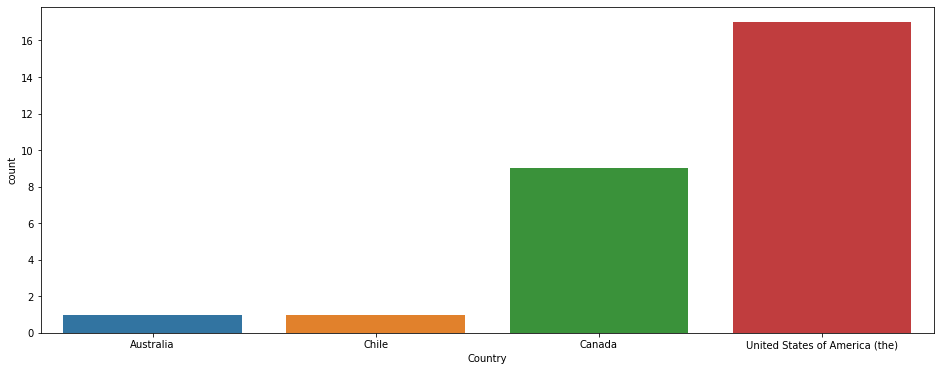

In [27]:
plt.figure(figsize=(16, 6))
sns.countplot(x = 'Country', data = data_airport)

In [28]:
data_airport.pivot_table(index = 'Country', values = 'AirportName', aggfunc = 'count')

,AirportName
Country,
Australia,1
Canada,9
Chile,1
United States of America (the),17


It is necessary to check the amount of data collected for each airport to make sure that the data is collected evenly. So I count the number of records per airport. Countplot below shows that the number of records is approximately the same for each airport.

Text(0.5, 1.0, 'Records for each airport')

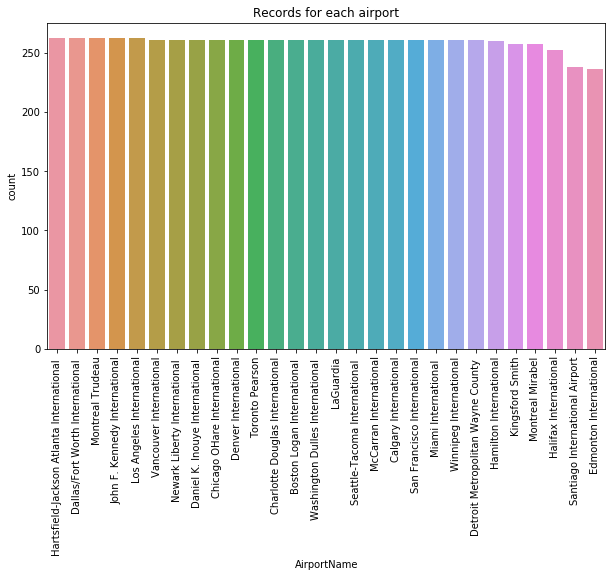

In [29]:
plt.figure(figsize=(10, 6))
plt_1 = sns.countplot(data = data, x = "AirportName",
              order = data['AirportName'].value_counts().index)
plt_1.set_xticklabels(plt_1.get_xticklabels(), rotation=90)
plt_1.set_title("Records for each airport")

At the next step I calculate the average traffic on each day of the week (*PercentOfBaseline*) for each airport.

In [30]:
data.pivot_table(values='PercentOfBaseline', index=['AirportName','Country'], 
                 columns = 'Weekday', aggfunc = 'mean')

,Weekday,Fri,Mon,Sat,Sun,Thu,Tue,Wed
AirportName,Country,,,,,,,
Boston Logan International,United States of America (the),63.567568,64.162162,62.432432,63.351351,61.432432,68.447368,69.315789
Calgary International,Canada,88.729730,91.189189,77.864865,89.783784,91.513514,97.131579,90.157895
Charlotte Douglas International,United States of America (the),75.243243,78.216216,61.000000,63.783784,81.378378,83.868421,83.684211
Chicago OHare International,United States of America (the),72.810811,73.351351,70.135135,60.891892,76.783784,78.394737,78.921053
Dallas/Fort Worth International,United States of America (the),77.729730,75.921053,68.324324,58.918919,78.729730,81.605263,85.368421
Daniel K. Inouye International,United States of America (the),81.648649,86.567568,80.864865,86.189189,85.783784,87.552632,83.736842
Denver International,United States of America (the),63.081081,55.783784,47.135135,41.189189,59.891892,60.763158,64.473684
Detroit Metropolitan Wayne County,United States of America (the),48.675676,44.945946,46.432432,40.351351,48.351351,52.184211,50.868421
Edmonton International,Canada,77.944444,70.000000,64.192308,81.400000,71.459459,77.789474,76.473684


Let's build a heat map for greater clarity.

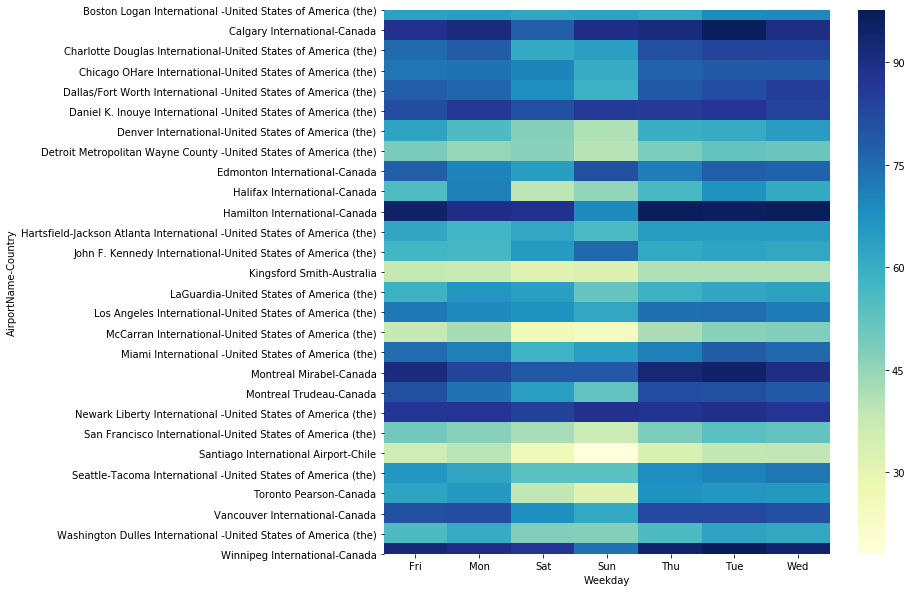

In [31]:
plt.figure(figsize=(10, 10))
avg_PercentOfBaseline_by_airport = data.pivot_table(
    values='PercentOfBaseline', index=['AirportName','Country'], columns = 'Weekday', aggfunc = 'mean')
sns.heatmap(avg_PercentOfBaseline_by_airport, cmap="YlGnBu")

There are the three airports with the least average traffic are especially highlighted on the heat map:
 + Santiago International Airport (Chile)
 + Kingsford Smith (Australia)
 + McCarran International (USA)

In [32]:
show_these_airports = ['Santiago International Airport', 'Kingsford Smith', 'McCarran International']
avg_PercentOfBaseline_by_airport.loc[show_these_airports]

,Weekday,Fri,Mon,Sat,Sun,Thu,Tue,Wed
AirportName,Country,,,,,,,
Kingsford Smith,Australia,38.243243,37.135135,31.727273,32.216216,41.135135,41.315789,41.631579
McCarran International,United States of America (the),37.675676,42.567568,26.675676,24.027027,41.837838,46.473684,47.789474
Santiago International Airport,Chile,36.138889,40.135135,26.343750,18.100000,33.540541,38.315789,38.657895


Average proportion of trips on the particular weekday as compared to avg number of trips on the same day of week in baseline period i.e 1st February 2020 - 15th March 2020 is less than 50% for these airports. Two out of three airports are situated in Australia and Chile. It can be assumed that the low *PercentOfBaseline* rate may be associated with strict restrictive measures in these countries. So it is interesting to test the hypothesis about the *PercentOfBaseline* difference in different countries 

### Hypothesis testing

In [24]:
# data.groupby(['AirportName', 'Country']).agg({'PercentOfBaseline': ['mean']})

In order to check that the *PercentOfBaseline* is different for different countries, we want to apply the Student criterion, however, we should to check:
  + Data normality
  + Equality of variances

Let's check if our data has a normal distribution. For that we can use two criteria of the scipy Python library with the stats module: Shapiro-Wilk test and Pearson's chi-squared test. Null hypothesis - data are normally distributed, alternative hypothesis - data are not normally distributed.

In [34]:
USA = data[data['Country'] == 'United States of America (the)']['PercentOfBaseline']

In [35]:
Canada = data[data['Country'] == 'Canada']['PercentOfBaseline']

In [36]:
Chile = data[data['Country'] == 'Chile']['PercentOfBaseline']

In [37]:
Australia = data[data['Country'] == 'Australia']['PercentOfBaseline']

In [38]:
def four_histograms (x, y, z, w):

   """
   Функция, которая построит четыре гистограммы на одной картинке.
   Дополнительно пунктирными линиями указываются средние значения выборок.
   x: вектор pd.Series
   y: вектор pd.Series
   z: вектор pd.Series
   w: вектор pd.Series
   """
   plt.figure(figsize=(10, 6))
   x.hist(alpha=0.5, weights=[1./len(x)]*len(x))
   y.hist(alpha=0.5, weights=[1./len(y)]*len(y))
   z.hist(alpha=0.5, weights=[1./len(z)]*len(z))
   w.hist(alpha=0.5, weights=[1./len(w)]*len(w))
   plt.axvline(x.mean(), color = 'red', alpha = 0.8, linestyle = 'dashed')
   plt.axvline(y.mean(), color = 'blue', alpha = 0.8, linestyle = 'dashed')
   plt.axvline(z.mean(), color = 'green', alpha = 0.8, linestyle = 'dashed')
   plt.axvline(w.mean(), color = 'yellow', alpha = 0.8, linestyle = 'dashed')
   plt.legend(['USA', 'Canada', 'Chile', 'Australia'])

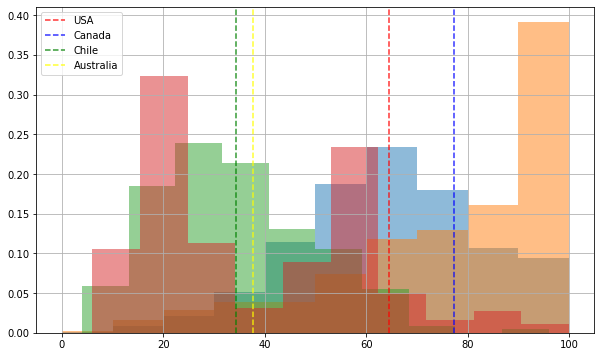

In [39]:
#Вызываем функцию для определенных выше векторов: USA, Canada, Chile, Australia.
four_histograms (USA, Canada, Chile, Australia)

In [42]:
#USA
stat, p = scipy.stats.shapiro(USA) # критерий Шапиро-Уилка
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('USA: Data are normally distributed (Shapiro-Wilk test)') # принять гипотезу о нормальности
else:
    print('USA: Data are not normally distributed (Shapiro-Wilk test)') # отклонить гипотезу о нормальности
    
    
stat, p = scipy.stats.normaltest(USA) # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('USA: Data are normally distributed (Pearson chi-squared test)') # принять гипотезу о нормальности
else:
    print('USA: Data are not normally distributed (Pearson chi-squared test)') # отклонить гипотезу о нормальности

Statistics=0.991, p-value=0.000
USA: Data are not normally distributed (Shapiro-Wilk test)
Statistics=13.976, p-value=0.001
USA: Data are not normally distributed (Pearson chi-squared test)


In [43]:
#Canada
stat, p = scipy.stats.shapiro(Canada) # критерий Шапиро-Уилка
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Canada: Data are normally distributed (Shapiro-Wilk test)') # принять гипотезу о нормальности
else:
    print('Canada: Data are not normally distributed (Shapiro-Wilk test)') # отклонить гипотезу о нормальности
    
    
stat, p = scipy.stats.normaltest(Canada) # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Canada: Data are normally distributed (Pearson chi-squared test)') # принять гипотезу о нормальности
else:
    print('Canada: Data are not normally distributed (Pearson chi-squared test)') # отклонить гипотезу о нормальности

Statistics=0.881, p-value=0.000
Canada: Data are not normally distributed (Shapiro-Wilk test)
Statistics=270.606, p-value=0.000
Canada: Data are not normally distributed (Pearson chi-squared test)


In [44]:
#Chile
stat, p = scipy.stats.shapiro(Chile) # критерий Шапиро-Уилка
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Chile: Data are normally distributed (Shapiro-Wilk test)') # принять гипотезу о нормальности
else:
    print('Chile: Data are not normally distributed (Shapiro-Wilk test)') # отклонить гипотезу о нормальности
    
    
stat, p = scipy.stats.normaltest(Chile) # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Chile: Data are normally distributed (Pearson chi-squared test)') # принять гипотезу о нормальности
else:
    print('Chile: Data are not normally distributed (Pearson chi-squared test)') # отклонить гипотезу о нормальности

Statistics=0.967, p-value=0.000
Chile: Data are not normally distributed (Shapiro-Wilk test)
Statistics=16.285, p-value=0.000
Chile: Data are not normally distributed (Pearson chi-squared test)


In [45]:
#Australia
stat, p = scipy.stats.shapiro(Australia) # критерий Шапиро-Уилка
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Australia: Data are normally distributed (Shapiro-Wilk test)') # принять гипотезу о нормальности
else:
    print('Australia: Data are not normally distributed (Shapiro-Wilk test)') # отклонить гипотезу о нормальности
    
    
stat, p = scipy.stats.normaltest(Australia) # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Australia: Data are normally distributed (Pearson chi-squared test)') # принять гипотезу о нормальности
else:
    print('Australia: Data are not normally distributed (Pearson chi-squared test)') # отклонить гипотезу о нормальности

Statistics=0.898, p-value=0.000
Australia: Data are not normally distributed (Shapiro-Wilk test)
Statistics=25.555, p-value=0.000
Australia: Data are not normally distributed (Pearson chi-squared test)


There are obvious outliers in the distributions that prevent the Student criterion from being applied. One could try to get rid of them, but that will not help. For example, yellow diagram has too large rightmost column. In this case, we will try to apply nonparametric criteria. Wilcoxon's test is applicable only for paired samples.  We have different objects in different samples. Therefore, we are left with the Mann-Whitney criterion.

In [46]:
#USAvsCanada
USA_Canada = stats.mannwhitneyu(USA, Canada)
print('USA vs Canada p-value:', USA_Canada[1])

#USAvsChile
USA_Chile = stats.mannwhitneyu(USA, Chile)
print('USA vs Chile p-value:', USA_Chile[1])

#USAvsAustralia
USA_Australia = stats.mannwhitneyu(USA, Australia)
print('USA vs Australia p-value:', USA_Australia[1])

#CanadavsAustralia
Canada_Australia = stats.mannwhitneyu(Canada, Australia)
print('Canada vs Australia p-value:', Canada_Australia[1])

#CanadavsChile
Canada_Chile = stats.mannwhitneyu(Canada, Chile)
print('Canada vs Chile p-value:', Canada_Chile[1])

USA vs Canada p-value: 4.346367254486856e-158
USA vs Chile p-value: 2.037659545753863e-95
USA vs Australia p-value: 2.801151808390541e-66
Canada vs Australia p-value: 1.3040046595153772e-93
Canada vs Chile p-value: 4.240903633968787e-104


p-value < 0.05 -> nill hypothesis should be rejected. Proportions of trips on this date as compared to Avg number of trips on the same day of week in baseline period i.e 1st February 2020 - 15th March 2020 in pairs USA and Canada, USA and Chile, USA and Australia, Canada and Australia, Canada and Chile differ significantly. 

In [109]:
#AustraliavsChile
Australia_Chile = stats.mannwhitneyu(Australia, Chile)
print('Australia vs Chile p-value:', Australia_Chile[1])

Australia vs Chile p-value: 0.3855446543425655


p-value > 0.05 -> nill hypothesis cannot be rejected. Proportions of trips on this date as compared to Avg number of trips on the same day of week in baseline period i.e 1st February 2020 - 15th March 2020 in Australia and Chile do not differ significantly. 

### Conclusion

We can conclude that Proportions of trips on this date as compared to Avg number of trips on the same day of week in baseline period i.e 1st February 2020 - 15th March 2020 significantly differ in different countries except the pair of countries Australia and Chile. So countries reacted differently to COVID-19's.